In [240]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [241]:
class model_params():
    def __init__(self, x_init=1.0, dt=0.1, time_horizon=10.0, num_trajectories=1):
        self.x_init = np.ones((1, num_trajectories)) * x_init
        self.dt = dt
        self.time_horizon = time_horizon
        self.num_steps = int(self.time_horizon/self.dt)
        self.time_vec = np.linspace(0, self.time_horizon, self.num_steps)
        self.num_trajectories = num_trajectories
        
        print('GENERATING NOISE')
        self.noise = random.normal(loc=0.0, scale = dt**(1/2), size=(self.num_steps, self.num_trajectories))
        print('COMPLETED NOISE GENERATION')

class climate_sde(model_params):
    def __init__(self, potential, x_init=0.0, dt=0.1,  time_horizon=100, num_trajectories=1, want_jumps: bool = True, jump_mult: float = 1.5):
        super().__init__(x_init=x_init, dt=dt, time_horizon=time_horizon, num_trajectories=num_trajectories)
        self.jump_mult = jump_mult
        
        if want_jumps == True:
            self.epsilon = (4.29 / np.log(self.time_horizon)) * self.jump_mult
        else:
            self.epsilon = 4.29 / np.log(self.time_horizon) - 0.001
        
        self.potential = potential

    def mu(self, x, t):
        return -self.potential(x, t)
    
    def sigma(self, x=0.0, t=0.0):
        return self.epsilon ** (1/2)

In [242]:
def const_neg_potential(x, t, period=100):
    t = 25                                   # re-define t to place minima on negative.
    a1 = 0
    a2 = -3.2
    sin_scale = 3
    a3 = sin_scale*np.sin(2*np.pi*t/period)
    a4 = 0.1
    a5 = -(3/5) * a3
    a6 = 1

    all_scale = 1.13
    
    return all_scale*(a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1)

In [243]:
deep_well_depth = 4.29
shallow_well_depth = 1.17

num_trajectories = 1

time_horizon = 100
dt = 0.001
num_steps = int(time_horizon/dt)

jump_mult_factor = 2
epsilon = jump_mult_factor * (deep_well_depth * 2) / np.log(time_horizon)


x_init = -1
x = np.empty(shape=(num_trajectories, num_steps))
x[:, 0] = x_init

t = np.linspace(0, time_horizon, num_steps)

noise = random.normal(loc=0, scale=np.sqrt(dt), size=(num_trajectories, num_steps))


def mu(x, t):
    return -const_neg_potential(x, t)

def sigma(x, t):
    return np.sqrt(epsilon)

In [244]:
for i in tqdm(range(num_trajectories - 1)):
    curr_t = t[i]
    curr_x = x[i, :]
    dW = noise[i, :]
    x[i+1, :] = curr_x + mu(curr_x, curr_t)*dt + sigma(curr_x, curr_t) * dW

0it [00:00, ?it/s]


In [245]:
t.shape

(100000,)

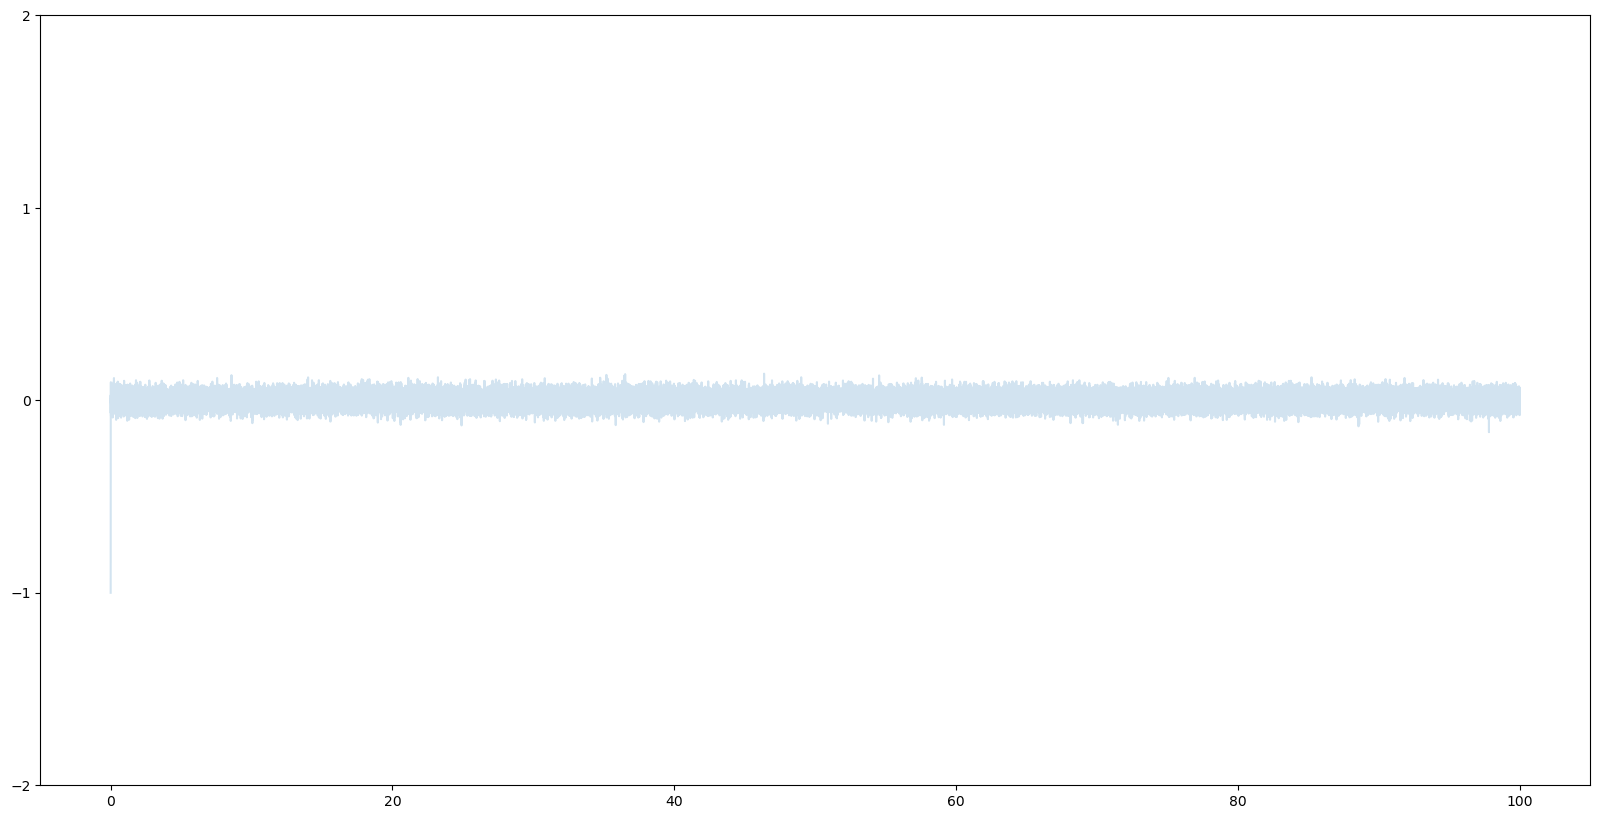

In [246]:
plt.figure(figsize=(20,10))
for i in range(num_trajectories):
    plt.plot(t, x[i], alpha=0.2)
plt.yticks([-2, -1, 0, 1, 2])
plt.show()